# Binary classification using KNN and SVM

This exercise is trying to accomplish the following:

- it is assumed you already have a dataset that has been normalized with min-max to scale all the features from 0..1
- dataset contains two classes (normal, abnormal) 
- 2000 rows of normal data, 200 rows of abnormal data
- The procedure is shown in the graphic below. Both the normal traffic and the anomaly traffic data are downsampled to, on the one hand, keep some anomaly traffic for the final validation stage; on the second hand, the downsampling allows us to obtain a balanced data set for training the two-classes problems.
- The remaining data not used in the training and testing of the models is preserved for the final validation stage.
- Once the data is downsampled, it is normalized and a 10-fold cross validation is carried out independently for the two-classes problem and for the one-class problem, although the same random seed is used to obtain the same partitions in each case for comparison reasons. 
- In the two-classes problem, all the partitions may include normal and anomaly instances. However, in the one-class problem, the partitions are prepared only with the normal traffic instances; the anomaly instances are used to measure the performance of the models obtained for each fold. Interestingly, the normalization for the one-class problem is determined exclusively with data from normal traffic only.
- A final validation stage includes all the data that has not been used in training and testing; this is an unbalanced data set containing instances from normal traffic and from anomalies. 
- The aim of this validation stage is to compare the behavior of the different modeling techniques included in this comparison, so conclusions could be extracted.
- the "normal" traffic (2000 lines) is the "negative class", while the "abnormal" traffic (200 lines) is the "positive class"



## Design of experiment
<img src=https://raw.githubusercontent.com/nickjeffrey/sklearn/master/images/fig03_experimental_setup.png>

In [1]:
# Based on # Stat479: Machine Learning -- L02: kNN in Python
# https://github.com/rasbt/stat479-machine-learning-fs18/blob/master/02_knn/02_knn_demo.ipynb
# uses my own custom dataset instead of the provided iris dataset

# 0 - General Imports



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# KNN and SVM algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# 1 - Load Dataset into a Pandas DataFrame


In [3]:
#df_data = pd.read_csv('c:/temp/data4.csv')
df_data = pd.read_csv('c:/temp/data5.csv')  #overwrote 100 lines of abnormal data with normal data to skew results
#df_data = pd.read_csv('https://raw.githubusercontent.com/nickjeffrey/sklearn/master/dataset.csv')

In [4]:
# look at the top few rows of the data (should show the abnormal class in column 35)
df_data.head()

,seconds_since_epoch,datestamp,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,water_pump_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,...,temps3_soil_temperature_C,latency_iotgateway_ms,latency_logcollector_ms,packetloss_iotgateway,packetloss_logcollector,auth_success_mqtt_to_hmi,auth_failure_mqtt_to_hmi,auth_success_ssh_to_iogateway,auth_failure_ssh_to_iotgateway,class
0,1673334002,0:00,0.0,0.0,0.0,0.928144,0.0,0.323232,0.12,0.10,...,0.436082,0.918065,0.273340,0.541436,0.328748,0.476190,0.35,0.272727,0.272727,abnormal
1,1673334062,0:01,0.0,0.0,0.0,0.622754,0.0,0.030303,0.16,0.10,...,0.241837,0.970968,0.579357,0.353591,0.418157,0.666667,0.60,0.909091,0.363636,abnormal
2,1673334122,0:02,0.0,0.0,0.0,0.119760,0.0,0.151515,0.00,0.31,...,0.152186,0.088387,0.096992,0.266575,0.284732,0.095238,0.30,0.636364,0.454545,abnormal
3,1673334182,0:03,0.0,0.0,0.0,0.646707,0.0,0.262626,0.08,0.16,...,0.037631,0.800000,0.391079,0.361878,0.364512,0.095238,0.30,0.909091,0.818182,abnormal
4,1673334242,0:04,0.0,0.0,0.0,0.532934,0.0,0.323232,0.31,0.15,...,0.376314,0.861935,0.200207,0.407459,0.134801,0.380952,0.65,0.181818,0.545455,abnormal


In [5]:
# look at the bottom few rows of the data (should show the normal class in column 35)
df_data.tail()

,seconds_since_epoch,datestamp,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,water_pump_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,...,temps3_soil_temperature_C,latency_iotgateway_ms,latency_logcollector_ms,packetloss_iotgateway,packetloss_logcollector,auth_success_mqtt_to_hmi,auth_failure_mqtt_to_hmi,auth_success_ssh_to_iogateway,auth_failure_ssh_to_iotgateway,class
2195,1673453753,9:15,0.595125,0.597490,0.586031,0.152174,0.0,0.300000,0.366667,0.366667,...,0.184911,0.315044,0.048364,0.0,0.0,0.0,0.0,0.000000,0.0,normal
2196,1673453813,9:16,0.497272,0.554383,0.540378,0.021739,0.0,0.300000,0.400000,0.400000,...,0.199704,0.249558,0.266003,0.0,0.0,0.0,0.0,0.166667,1.0,normal
2197,1673453873,9:17,0.508549,0.521099,0.510004,0.021739,0.0,0.533333,0.466667,0.466667,...,0.199704,0.024779,0.201991,0.0,0.0,0.0,0.0,0.166667,0.0,normal
2198,1673453933,9:18,0.600218,0.562750,0.541833,0.141304,0.0,0.366667,0.533333,0.500000,...,0.147929,0.097345,0.307255,0.0,0.0,0.0,0.0,0.500000,1.0,normal
2199,1673453993,9:19,0.565296,0.595125,0.575664,0.000000,0.0,0.333333,0.533333,0.300000,...,0.207101,0.113274,0.056899,0.0,0.0,0.0,0.0,0.500000,1.0,normal


In [6]:
# show number of rows in dataset
print ( len(df_data) )


2200


In [7]:
#view dimensions of dataset (rows and columns)
df_data.shape  

(2200, 35)

In [8]:
# check to see if there are any missing values from the dataset

# all of the results should be zero, which would indicate there are not any null values in the dataset
# if there are any results greater than zero, it would indicate that some pieces of data are missing and should be cleaned up.
df_data.isnull().sum()

seconds_since_epoch               0
datestamp                         0
sp1_watts_generated               0
sp2_watts_generated               0
sp3_watts_generated               0
iot_gateway_watt_consumption      0
water_pump_watt_consumption       0
valve1_watt_consumption           0
valve2_watt_consumption           0
valve3_watt_consumption           0
ms1_watt_consumption              0
ms2_watt_consumption              0
ms3_watt_consumption              0
temp1_watt_consumption            0
temp2_watt_consumption            0
temp3_watt_consumption            0
battery_watt_hours                0
valve1_litres                     0
valve2_litres                     0
valve3_litres                     0
ms1_soil_moisture_pct             0
ms2_soil_moisture_pct             0
ms3_soil_moisture_pct             0
temps1_soil_temperature_C         0
temps2_soil_temperature_C         0
temps3_soil_temperature_C         0
latency_iotgateway_ms             0
latency_logcollector_ms     

In [9]:
# show frequency distribution of values in variables

for var in df_data.columns:
    print(df_data[var].value_counts())

    

1673334002    1
1673410193    1
1673409833    1
1673409893    1
1673409953    1
             ..
1673365673    1
1673365613    1
1673365553    1
1673365493    1
1673453993    1
Name: seconds_since_epoch, Length: 2200, dtype: int64
0:00     3
2:18     3
2:08     3
2:09     3
2:10     3
        ..
14:16    1
14:17    1
14:18    1
14:19    1
23:59    1
Name: datestamp, Length: 1440, dtype: int64
0.000000    1040
0.166606       6
0.184976       5
0.798836       5
0.180247       5
            ... 
0.905784       1
0.332303       1
0.921972       1
0.369953       1
0.600218       1
Name: sp1_watts_generated, Length: 816, dtype: int64
0.000000    1040
0.180793       6
0.185340       5
0.196253       5
0.184067       5
            ... 
0.863951       1
0.799200       1
0.881957       1
0.751546       1
0.595125       1
Name: sp2_watts_generated, Length: 833, dtype: int64
0.000000    1040
0.188978       5
0.391415       5
0.178065       4
0.362132       4
            ... 
0.892324       1
0.8821

In [10]:
#show the names of the columns (also called feature names)
df_data.columns

Index(['seconds_since_epoch', 'datestamp', 'sp1_watts_generated',
       'sp2_watts_generated', 'sp3_watts_generated',
       'iot_gateway_watt_consumption', 'water_pump_watt_consumption',
       'valve1_watt_consumption', 'valve2_watt_consumption',
       'valve3_watt_consumption', 'ms1_watt_consumption',
       'ms2_watt_consumption', 'ms3_watt_consumption',
       'temp1_watt_consumption', 'temp2_watt_consumption',
       'temp3_watt_consumption', 'battery_watt_hours', 'valve1_litres',
       'valve2_litres', 'valve3_litres', 'ms1_soil_moisture_pct',
       'ms2_soil_moisture_pct', 'ms3_soil_moisture_pct',
       'temps1_soil_temperature_C', 'temps2_soil_temperature_C',
       'temps3_soil_temperature_C', 'latency_iotgateway_ms',
       'latency_logcollector_ms', 'packetloss_iotgateway',
       'packetloss_logcollector', 'auth_success_mqtt_to_hmi',
       'auth_failure_mqtt_to_hmi', 'auth_success_ssh_to_iogateway',
       'auth_failure_ssh_to_iotgateway', 'class'],
      dtype='obje

In [11]:
#show summary info about dataset
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   seconds_since_epoch             2200 non-null   int64  
 1   datestamp                       2200 non-null   object 
 2   sp1_watts_generated             2200 non-null   float64
 3   sp2_watts_generated             2200 non-null   float64
 4   sp3_watts_generated             2200 non-null   float64
 5   iot_gateway_watt_consumption    2200 non-null   float64
 6   water_pump_watt_consumption     2200 non-null   float64
 7   valve1_watt_consumption         2200 non-null   float64
 8   valve2_watt_consumption         2200 non-null   float64
 9   valve3_watt_consumption         2200 non-null   float64
 10  ms1_watt_consumption            2200 non-null   float64
 11  ms2_watt_consumption            2200 non-null   float64
 12  ms3_watt_consumption            22

In [12]:
# show data types 
df_data.dtypes

seconds_since_epoch                 int64
datestamp                          object
sp1_watts_generated               float64
sp2_watts_generated               float64
sp3_watts_generated               float64
iot_gateway_watt_consumption      float64
water_pump_watt_consumption       float64
valve1_watt_consumption           float64
valve2_watt_consumption           float64
valve3_watt_consumption           float64
ms1_watt_consumption              float64
ms2_watt_consumption              float64
ms3_watt_consumption              float64
temp1_watt_consumption            float64
temp2_watt_consumption            float64
temp3_watt_consumption            float64
battery_watt_hours                float64
valve1_litres                     float64
valve2_litres                     float64
valve3_litres                     float64
ms1_soil_moisture_pct             float64
ms2_soil_moisture_pct             float64
ms3_soil_moisture_pct             float64
temps1_soil_temperature_C         

In [13]:
# We should drop any redundant columns from the dataset which does not have any predictive power. 

#In this example, seconds_since_epoch and datestamp do not have any predictive value because they are just timestamps
df_data.drop('seconds_since_epoch', axis=1, inplace=True)
df_data.drop('datestamp', axis=1, inplace=True)


# These columns are for ping packet loss.  
# If the value is ever >0, the data will be in the "abnormal" class.
# In other words, this allows the learning model to "cheat" by ignoring all the other features if this value is ever >0
# So, this particular data feature should be tracked not with machine learning, but with a simple threshold-based detection.
df_data.drop('packetloss_iotgateway', axis=1, inplace=True)
df_data.drop('packetloss_logcollector', axis=1, inplace=True)


# Same issue as the previous ping features.
# These colums are for machine-to-machine data transfers, if the authentication failures are ever >0, the data is abnormal
# In other words, this allows the learning model to "cheat" by ignoring all the other features if this value is ever >0
# So, this particular data feature should be tracked not with machine learning, but with a simple threshold-based detection.
df_data.drop('auth_failure_mqtt_to_hmi', axis=1, inplace=True)
df_data.drop('auth_failure_ssh_to_iotgateway', axis=1, inplace=True)


In [14]:
#Look at the dataset again, you should see several columns have been dropped
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sp1_watts_generated            2200 non-null   float64
 1   sp2_watts_generated            2200 non-null   float64
 2   sp3_watts_generated            2200 non-null   float64
 3   iot_gateway_watt_consumption   2200 non-null   float64
 4   water_pump_watt_consumption    2200 non-null   float64
 5   valve1_watt_consumption        2200 non-null   float64
 6   valve2_watt_consumption        2200 non-null   float64
 7   valve3_watt_consumption        2200 non-null   float64
 8   ms1_watt_consumption           2200 non-null   float64
 9   ms2_watt_consumption           2200 non-null   float64
 10  ms3_watt_consumption           2200 non-null   float64
 11  temp1_watt_consumption         2200 non-null   float64
 12  temp2_watt_consumption         2200 non-null   f

In [15]:
# look at the dimensions (rows and columns) of the dataset again after removing a few colums
#view dimensions of dataset (rows and columns)
df_data.shape  

(2200, 29)

# 2 - Get Features into a NumPy Array

In [16]:
# Question: how many features should I use?  Want to avoid overfitting the model.


#X = df_data[['latency_iotgateway_ms', 'latency_logcollector_ms']].values
X = df_data.values  #assign the entire dataframe to X

# Drop the "class" column from this array because we only want the data with predictive values, 
# and the "class" column is the binary classifier

# [rows,colums], so in this example, do nothing with the rows (before the first comma), 
# use negative indexing -1 to drop the last column
X = X[:,:-1]



In [17]:
# QUESTION FOR ARASH: 
# looking back 2 steps, the df_data.shape command tells us there are only 30 colums, 
# so what is this command showing us?


# Looks like column 33 is the class.  What does this command do?
# show colums begin:33, rows beginning:end
X[:33, :]



array([[0.0, 0.0, 0.0, 0.928143713, 0.0, 0.323232323, 0.12, 0.1,
        0.428571429, 0.142857143, 0.285714286, 0.285714286, 0.714285714,
        0.428571429, 0.380846883, 0.309499832, 0.183244326, 0.167167167,
        0.706149126, 0.740298706, 0.413726406, 0.349450549, 0.151098901,
        0.436081904, 0.918064516, 0.273340249, 0.476190476, 0.272727273],
       [0.0, 0.0, 0.0, 0.622754491, 0.0, 0.03030303, 0.16, 0.1,
        0.428571429, 0.142857143, 0.142857143, 0.571428571, 0.571428571,
        0.571428571, 0.37946425, 0.075528701, 0.213618158, 0.168501835,
        0.619114312, 0.725030004, 0.143400253, 0.156593407, 0.235164835,
        0.241837299, 0.970967742, 0.579356846, 0.666666667, 0.909090909],
       [0.0, 0.0, 0.0, 0.119760479, 0.0, 0.151515152, 0.0, 0.31, 0.0,
        0.142857143, 0.571428571, 0.285714286, 0.857142857, 0.285714286,
        0.378639521, 0.205438066, 0.012016021, 0.302969636, 0.402761104,
        0.5210028, 0.045554592, 0.418681319, 0.170879121, 0.152185944,

# 3 - Get Class Labels into a NumPy Array


In [18]:
# This will add a new column called "ClassLabel", which converts the "normal|abnormal" 
# alphabetic content of the "class" column to an integer

label_dict = {'normal': 0, 'abnormal': 1}

df_data['ClassLabel'] = df_data['class'].map(label_dict)


In [19]:
# look at the top few rows of the data (should show the abnormal class in the last column)
df_data.head()

,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,water_pump_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,ms1_watt_consumption,ms2_watt_consumption,...,ms3_soil_moisture_pct,temps1_soil_temperature_C,temps2_soil_temperature_C,temps3_soil_temperature_C,latency_iotgateway_ms,latency_logcollector_ms,auth_success_mqtt_to_hmi,auth_success_ssh_to_iogateway,class,ClassLabel
0,0.0,0.0,0.0,0.928144,0.0,0.323232,0.12,0.10,0.428571,0.142857,...,0.413726,0.349451,0.151099,0.436082,0.918065,0.273340,0.476190,0.272727,abnormal,1
1,0.0,0.0,0.0,0.622754,0.0,0.030303,0.16,0.10,0.428571,0.142857,...,0.143400,0.156593,0.235165,0.241837,0.970968,0.579357,0.666667,0.909091,abnormal,1
2,0.0,0.0,0.0,0.119760,0.0,0.151515,0.00,0.31,0.000000,0.142857,...,0.045555,0.418681,0.170879,0.152186,0.088387,0.096992,0.095238,0.636364,abnormal,1
3,0.0,0.0,0.0,0.646707,0.0,0.262626,0.08,0.16,0.714286,0.571429,...,0.043287,0.141758,0.437912,0.037631,0.800000,0.391079,0.095238,0.909091,abnormal,1
4,0.0,0.0,0.0,0.532934,0.0,0.323232,0.31,0.15,0.857143,0.428571,...,0.031882,0.166484,0.339011,0.376314,0.861935,0.200207,0.380952,0.181818,abnormal,1


In [20]:
# look at the bottom few rows of the data (should show the normal class in the last column)
df_data.tail()

,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,water_pump_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,ms1_watt_consumption,ms2_watt_consumption,...,ms3_soil_moisture_pct,temps1_soil_temperature_C,temps2_soil_temperature_C,temps3_soil_temperature_C,latency_iotgateway_ms,latency_logcollector_ms,auth_success_mqtt_to_hmi,auth_success_ssh_to_iogateway,class,ClassLabel
2195,0.595125,0.597490,0.586031,0.152174,0.0,0.300000,0.366667,0.366667,0.00,0.0,...,0.073948,0.192308,0.199704,0.184911,0.315044,0.048364,0.0,0.000000,normal,0
2196,0.497272,0.554383,0.540378,0.021739,0.0,0.300000,0.400000,0.400000,0.00,0.0,...,0.002061,0.162722,0.199704,0.199704,0.249558,0.266003,0.0,0.166667,normal,0
2197,0.508549,0.521099,0.510004,0.021739,0.0,0.533333,0.466667,0.466667,0.00,0.0,...,0.148988,0.184911,0.140533,0.199704,0.024779,0.201991,0.0,0.166667,normal,0
2198,0.600218,0.562750,0.541833,0.141304,0.0,0.366667,0.533333,0.500000,0.00,0.0,...,0.095769,0.147929,0.192308,0.147929,0.097345,0.307255,0.0,0.500000,normal,0
2199,0.565296,0.595125,0.575664,0.000000,0.0,0.333333,0.533333,0.300000,0.25,0.0,...,0.002182,0.177515,0.170118,0.207101,0.113274,0.056899,0.0,0.500000,normal,0


In [39]:
# QUESTION FOR ARASH: instead of hardcoding the last column number (which may change if we drop a few colums),
# should we use y[:-1] negative indexing to show us the last column on the right hand side?

# show the Class Labels (should be 0 normal or 1 for abnormal)
y = df_data['ClassLabel'].values
y[:33]
#y[:-1]



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

# 4 - Shuffle Dataset and Create Training and Test Subsets


In [22]:
# count the size of the dataset (number of rows)

indices = np.arange(y.shape[0])
indices

array([   0,    1,    2, ..., 2197, 2198, 2199])

In [23]:
# randomize the dataset before splitting
# this is a seeded deterministic shuffle 
# in this example, a seed value of 123 is given, which makes the output deterministic, so the experiment is reproducible
# any seed value can be chosen, but it should remain consistent so the results can be reproduced

rnd = np.random.RandomState(123)
shuffled_indices = rnd.permutation(indices)
shuffled_indices

array([ 809,  403,  304, ..., 1766, 1122, 1346])

In [24]:
# before we shuffle the data, downsample the "abnormal" or "positive" class down, 
# by splitting the 200 lines to 160/40 (aka 80%/20%)

# shuffle within the positive and negative classes to avoid bias
# create a new array that only includes the first 200 rows
X_pos = X[:200]  #implies from beginning up to (but not including) 200
X_neg = X[200:]  #implies from 200 to end
y_pos = y[:200]
y_neg = y[200:]  



# shuffle the positive indices
indices_pos = np.arange(X_pos.shape[0])
pos_shuffled_indices = rnd.permutation(indices_pos)
X_pos_shuffled = X_pos[pos_shuffled_indices]
y_pos_shuffled = y_pos[pos_shuffled_indices]


# shuffle the negative indices
indices_neg = np.arange(X_neg.shape[0])
neg_shuffled_indices = rnd.permutation(indices_neg)
X_neg_shuffled = X_neg[neg_shuffled_indices]
y_neg_shuffled = y_neg[neg_shuffled_indices]



# grab the first 40 lines (20%) of the abormal (positive) class for test data 
X_test_pos, y_test_pos = X_pos_shuffled[:40],y_pos_shuffled[:40] 

# grab the last 160 lines (80%) of the abnormal (positive) class for training data
X_train_pos, y_train_pos = X_pos_shuffled[40:],y_pos_shuffled[40:]  #only the starting row is shown, last row (200) is implied

# we want the abnormal/normal classes to be balanced, so grab the same amount of data (160 lines) as the previous step
# rows 0 to 160 will be the first 160 lines of the "normal" or negative class
# first value is included, last value is not included :160 means 0 is implied, 160 is *not* included
X_train_neg, y_train_neg = X_neg_shuffled[:160],y_neg_shuffled[:160]

# the remaining lines are for test
X_test_neg, y_test_neg = X_neg_shuffled[160:],y_neg_shuffled[160:] 






In [25]:
# sanity check to visualize the labels, make sure the classLabel boundaries are correct
# this confirms that we split up the data correcly into training data and test data in the previous step

print ("y testing data for positive/abnormal class, should be all ones:")
print (y_test_pos)   # should output all 1
print ("")
print ("y testing data for negative/normal class, should be all zeros:")
print (y_test_neg)   # should output all 0
print ("")
print ("y training data for positive/abnormal class, should be all ones:")
print (y_train_pos)  # should output all 1
print ("")
print ("y training data for negative/normal class, should be all zeros:")
print (y_train_neg)  # should output all 0

y testing data for positive/abnormal class, should be all ones:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]

y testing data for negative/normal class, should be all zeros:
[0 0 0 ... 0 0 0]

y training data for positive/abnormal class, should be all ones:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]

y training data for negative/normal class, should be all zeros:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

In [26]:
# create the training set and test set

#concatentate the 2 python arrays of positive and negative classes into a single array that will be used to train the model
X_train = np.concatenate((X_train_pos,X_train_neg))
y_train = np.concatenate((y_train_pos,y_train_neg))

X_test = np.concatenate((X_test_pos,X_test_neg))
y_test = np.concatenate((y_test_pos,y_test_neg))

# 4a - perform 10-fold cross-validation with SVM and KNN algorithms

## SVM algorithm

In [40]:
# sklearn has a cross-validation function that we will use here
# this function will combine your datasets and perform cross-validation
from sklearn.model_selection import cross_val_score

# the random_state is a seed value that we use for reproducability
# clf is short for classifier, which refers to the algorithm being used KNN, SVM, etc

clf = svm.SVC(kernel='linear', C=1, random_state=42)

# this where all the training and validation happens
# cv=number of cross-validations you want to do
# this folds the data cv times, then returns the accuracy of each fold, showing average performance of $cv splits
scores = cross_val_score(clf, X_train, y_train, cv=10)



## KNN algorithm (not yet written)

In [41]:
##clf = KNeighborsClassifier(kernel='linear' n_neighbors=3, random_state=42)
#clf = KNeighborsClassifier()

## Train/Fit the model 
#clf.fit(X_train, y_train)

## Make prediction using the model
##X_pred = [5.1, 3.2, 1.5, 0.5]
#y_pred = clf.predict([X_train])

#print("Prediction is: {}".format(targets[y_pred]))


## algorithm accuracy

In [42]:

# print the scores for every folder (cv=10)
scores


array([0.875  , 0.8125 , 0.78125, 0.75   , 0.90625, 0.75   , 0.8125 ,
       0.71875, 0.71875, 0.8125 ])

In [43]:
# average the scores of each folder
scores_average = np.mean(scores)
scores_average

0.79375

In [44]:
# perform the final validation

# train the function with the entire training set (without any splitting)
clf.fit (X_train,y_train)

SVC(C=1, kernel='linear', random_state=42)

In [45]:
# evaluate on the test set using the score function
# this returns a really high accuracy value, because this particular dataset is "unbalanced", 
# because there is way more of the negative class than the positive class.
# In other words, because this dataset is unbalanced, this accuracy result is misleading
clf.score (X_test,y_test)

0.5952127659574468

In [46]:
# perform a GridSearchCV function to find the optimal hyperparameter for K in KNN or C for SVM
from sklearn.model_selection import GridSearchCV

# define the grid we are going to search
# note we try the linear and rbf kernels
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

# combine the classifer model with the GridSearchCV classifier to calculate accuracy for all possibilities
svc = svm.SVC()  #instance of base classifier we want to search
clf = GridSearchCV(svc, parameters)
clf.fit (X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [47]:
# the optimal hyperparameter was calculated in the previous step.
sorted(clf.cv_results_.keys())


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [48]:
# we are most interested in the value of param_C and param_kernel
print (clf.cv_results_["param_C"])
print (clf.cv_results_["param_kernel"])
print (clf.cv_results_["params"])

# this output shows 4 optimal possibilities

[1 1 10 10]
['linear' 'rbf' 'linear' 'rbf']
[{'C': 1, 'kernel': 'linear'}, {'C': 1, 'kernel': 'rbf'}, {'C': 10, 'kernel': 'linear'}, {'C': 10, 'kernel': 'rbf'}]


# 5 - Doing Steps 1-4 in Scikit-Learn

In [49]:
##from sklearn.datasets import load_iris
#df_data = pd.read_csv('c:/temp/data3.csv')
#df_data.head()
#from sklearn.model_selection import train_test_split


#iris = load_iris()
#X, y = iris.data[:, 2:], iris.target
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                    test_size=0.3,
#                                                    random_state=123,
#                                                    shuffle=True)

# 6 - Plot Dataset

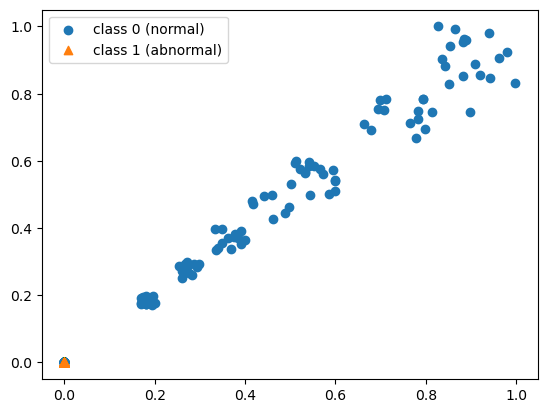

In [50]:
plt.scatter(X_train[y_train == 0, 0],
            X_train[y_train == 0, 1],
            marker='o',
            label='class 0 (normal)')

plt.scatter(X_train[y_train == 1, 0],
            X_train[y_train == 1, 1],
            marker='^',
            label='class 1 (abnormal)')

#plt.xlabel('latency_iotgateway_ms')
#plt.ylabel('latency_logcollector_ms')
#plt.xlabel('packetloss_iotgateway')
#plt.ylabel('packetloss_logcollector')

plt.legend(loc='upper left')

plt.show()

# 7 - Fit k-Nearest Neighbor Model

In [51]:
from sklearn.neighbors import KNeighborsClassifier


knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

# 8 - Use kNN Model to Make Predictions

In [52]:
y_pred = knn_model.predict(X_test)

In [53]:
num_correct_predictions = (y_pred == y_test).sum()
accuracy = (num_correct_predictions / y_test.shape[0]) * 100
print('Test set accuracy: %.2f%%' % accuracy)

Test set accuracy: 76.60%


# 8a - Confusion Matrix

In [54]:

# Confusion Matrix

# A confusion matrix is a table that is often used to describe the performance of a 
# classification model (or "classifier") on a set of test data for which the true values are known.
# Scikit-learn provides facility to calculate confusion matrix using the confusion_matrix method.

#import confusion_matrix
from sklearn.metrics import confusion_matrix

# Evaluate model
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[1405  435]
 [   5   35]]

True Positives(TP) =  1405

True Negatives(TN) =  35

False Positives(FP) =  435

False Negatives(FN) =  5


In [55]:
# Confusion matrix can also be obtained using crosstab method of pandas.
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1405,435,1840
1,5,35,40
All,1410,470,1880


# 8b - Accuracy of model


Calculate the following for each of the cross-validations: Accuracy, Sensitivity, Specificity, Geometric Mean

TP = True Positive

TN = True Negative

FP = False Positive

FN = False Negative

## Formulas:

Accuracy = ( TP + TN) / ( TP + TN + FP + RN)

Sensitivity = TP / (TP + FN)

Specificity = TN / (TP + FP)

Geometric Mean = $$\sqrt{Sensitivity * Specificity}$$



In [56]:
# calculate the mean, median, standard deviation for each cross-validation


# 8c - Classification Report

In [57]:
# Classification Report

# Another important report is the Classification report. 
# It is a text summary of the precision, recall, F1 score for each class. 
# Scikit-learn provides facility to calculate Classification report using the classification_report method.

In [58]:
#import classification_report
from sklearn.metrics import classification_report

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86      1840
           1       0.07      0.88      0.14        40

    accuracy                           0.77      1880
   macro avg       0.54      0.82      0.50      1880
weighted avg       0.98      0.77      0.85      1880



# 9 - Visualize Decision Boundary
You may need to install the mlxtend package. Open a command prompt and run:
conda install mlxtend –channel Conda-forge

In [60]:
from mlxtend.plotting import plot_decision_regions

#plot_decision_regions(X_test, y_test, knn_model)
#plt.xlabel('latency_iotgateway_ms')
#plt.ylabel('latency_logcollector_ms')
#plt.legend(loc='upper left')
#plt.show()

# Outstanding Questions
- there are a lot of features (columns) in the dataset.  How to avoid overfitting?
- how should axes be labeled on a scatterplot graph if there are more than 2 features?  Is this possible on a 2D graph?
- run the dataset through these 4 models: 2-class KNN, 2-class SVM, 1-class KNN, 1-class SVM
